# AdaBoostRegressor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.ensemble  import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection   import RandomizedSearchCV
import joblib

In [2]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# Split features/target
X_train = train.drop('Score', axis=1)
y_train = train['Score']
X_test  = test.drop('Score', axis=1)
y_test  = test['Score']

In [4]:
preprocessor = joblib.load("preprocessor_unfitted.joblib")

## Pipeline and RandomizedSearchCV

In [5]:
ada_pipe = Pipeline([
    ("prep",  preprocessor),
    ("model", AdaBoostRegressor(random_state=42))
])


In [6]:
#  “Light” hyper‐parameter distributions
ada_param_dist = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.01, 0.1, 1.0],
    "model__loss": ["linear", "square", "exponential"]
}

In [7]:
#  RandomizedSearchCV 
ada_search = RandomizedSearchCV(
    estimator           = ada_pipe,
    param_distributions = ada_param_dist,
    n_iter              = 20,    
    cv                  = 3,     # 3-fold CV
    scoring             = "neg_mean_squared_error",
    n_jobs              = -1,
    random_state        = 42,
    verbose             = 2
)

In [8]:
# Fit & find best
print("Searching AdaBoostRegressor…")
ada_search.fit(X_train, y_train)

Searching AdaBoostRegressor…
Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['WhiteElo',
                                                                                'EloDif']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Opening_name',
 

In [9]:
print(f"Best params:", ada_search.best_params_)
print(f"AdaBoostRegressor best CV MSE: {-ada_search.best_score_:.4f}")
best_ada = ada_search.best_estimator_

Best params: {'model__n_estimators': 200, 'model__loss': 'exponential', 'model__learning_rate': 0.01}
AdaBoostRegressor best CV MSE: 0.2264


In [10]:
# Final eval on test set
y_pred = best_ada.predict(X_test)
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test R²:  {r2_score(y_test, y_pred):.4f}")

Test MSE: 0.2277
Test MAE: 0.4599
Test R²:  0.0330


[learning_curve] Training set sizes: [  466  1651  2835  4020  5205  6389  7574  8758  9943 11128 12312 13497
 14681 15866 17051 18235 19420 20604 21789 22974 24158 25343 26527 27712
 28897 30081 31266 32450 33635 34820 36004 37189 38373 39558 40743 41927
 43112 44296 45481 46666]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of 120 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.9min finished


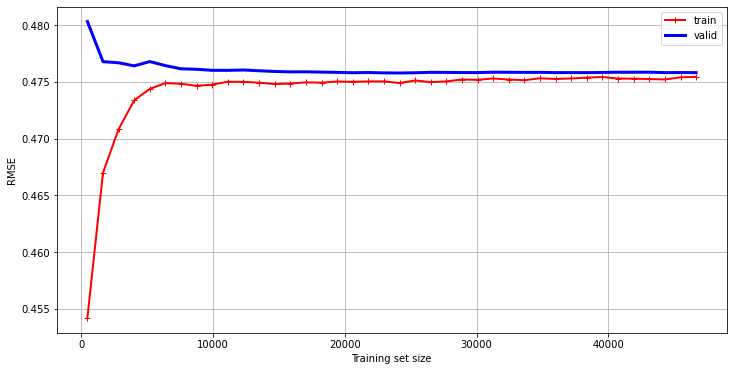

In [11]:
# Plot the learning curve for the AdaBoostRegressor
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(best_ada,
                                                         X_train, y_train,
                                                         train_sizes = np.linspace(0.01, 1.0, 40),
                                                         cv = 3,
                                                         scoring = "neg_root_mean_squared_error", 
                                                         n_jobs      = -1,
                                                         verbose     = 2 )

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

fig = plt.figure(figsize = (12, 6))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.show()

In [12]:
joblib.dump(best_ada, "best_ada_boost.joblib")

['best_ada_boost.joblib']